In [3]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))
sys.path.append(op.abspath('../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../')

# Compute the chi2 of an event w.r.t. the simulated signal curve

In this notebook, we'll try to compute efficiency a $\chi^2$ between the simulated signal shape and an event, and that for all the events of a dataframe.

## Libraries

In [4]:
import itertools
from copy import deepcopy

import pandas as pd

import numpy as np

from lib import plot as lp, rootdata as lrd, data, clustering

from project import defs, files, col, normalize, compute_chi2
from project.defs import dict_color_clu_labels
import data_cuts
from scripts.simulation.models import get_sig_model
import matplotlib.pyplot as plt

from numba import jit


In [5]:
randomise_discretisation = False

## Load ROOT file

In [65]:
list_voi = [
    'pos_max', #'pos_min',
    'std', 'pedestal',
    'std_pos', 'std_neg',
    'max', 'min', 'mean',
    'mid'
]

columns = [
    'max_m_mean',
    'min_std_pos_neg',
    'min_std_pos_neg_redpn',
    'max_m_mean_red',
    "min_m_mean",
    "mid_m_mean",
    "min_m_mean_red",
    "mid_m_mean_red",
]

other_columns = [
    "pos_first_neg_after_max",
    "nb_peaks_sup_80_wrt_min"
]

config_name = "run1_num1_layer_2"
file_path = files.get_path_processed_root(config_name)


dataframe, column_labels = files.load_and_process_dataframe(
    file_path, list_voi, columns, other_columns,
    branches=defs.list_samples_columns+["eta", "phi", "region", "detector"],
    verbose=True
)

Time taken to load the ROOT files: 0.22565078735351562
ROOT files loaded: /mnt/e/900GeV/processed/simulation/run1_num1_layer_2.root
COMPUTE VOIs
Time taken to compute the voi: 0.010033607482910156
Remove events with std == 0
COMPUTE COLUMNS (not already computed)


In [66]:
# data_cuts.apply_signal_cuts(dataframe)
data.cut_dataframe(dataframe, "min_std_pos_neg_redpn > 0.02")

Cut min_std_pos_neg_redpn > 0.02 -> efficiency 0.13073809777399084


## Computation

### Simulated signal shape

In [67]:
time_array, sig_array = get_sig_model()

Text(0, 0.5, 'Amplitude')

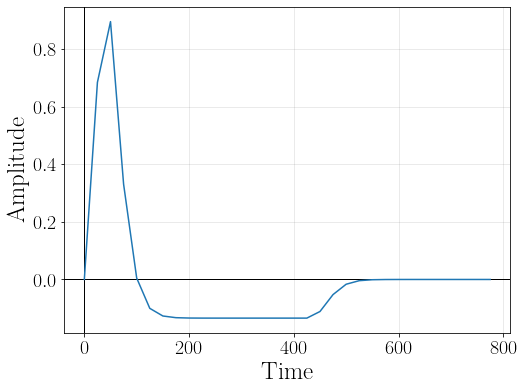

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=0, color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)
ax.plot(time_array, sig_array)
lp.set_default_grid(ax)
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

### Standardisation of the dataframe

First, we shift the events so that their mean is 0. Then, we adjust the amplitude so that the max of the simulated signal shape is one. The event dataframe is rather divided by its standard deviation.

Then, we will analyse how well this $\chi^2$ is. We expect that some true signal events have high $\chi^2$ value because the noise around the max is too large.

In [69]:
sig_array = (sig_array - np.mean(sig_array)) / np.max(sig_array)
sig_max = np.max(sig_array)

Text(0, 0.5, 'Amplitude')

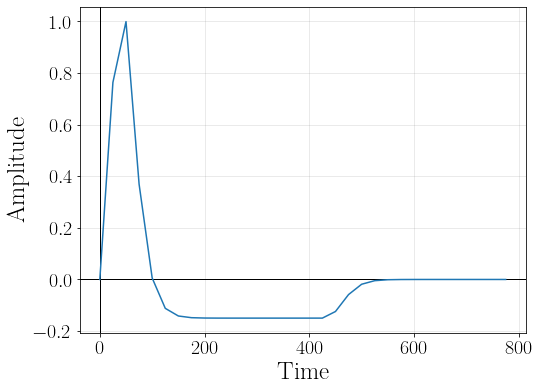

In [70]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=0, color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)
ax.plot(time_array, sig_array)
lp.set_default_grid(ax)
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

### Prepare the signal dataframe
To compare the simulation to an event, we need to enlarge the length of a signal. This way, it's be easier to align simulation and an event.


In [71]:
sig_array_red = np.array(sig_array, dtype=np.float_)
zeros_array = np.zeros(shape=defs.n_samples)

sig_array_red_big = np.concatenate((zeros_array, sig_array_red, zeros_array))
sig_pos_max = np.argmax(sig_array_red_big)

### Compute $\chi^2$

In [72]:
@jit(nopython=True)
def compute_chi2_array_to_sig(
    array: np.ndarray, sig_array: np.array, pos_max: np.array, sig_pos_max: int
)->np.array:
    """ Compute the chi2 between a set of samples and the simulated signal shape.

    Args:
        array: array of (events, samples)
        sig_array: simulated signal shape ; might be bigger than the number
            of samples (32) to allow for time translation
        pos_max: position of the max of each event in `array`
        sig_pos_max: position of the max of the signal
            (to avoid recomputing it)
        
    returns:
        chi2: reduced chi2 between each event and the simulated signal shape         
    """
    chi2 = np.empty(shape=len(array), dtype=np.float_)
    max_signal = sig_array[sig_pos_max]

    for i in range(len(array)): # Loop over the events
        pos_max_i = pos_max[i]
        scale = compute_chi2.compute_scale_numba(
            array[i], sig_array, pos_max_i, sig_pos_max
        )
        
        sig_start_pos = sig_pos_max - pos_max_i
        sig_end_pos = sig_start_pos + defs.n_samples
        chi2[i] = compute_chi2.compute_chi2_numba(
            array[i], sig_array[sig_start_pos:sig_end_pos] * scale
        )
    return chi2

def compute_chi2_dataframe_to_sig(
    dataframe: pd.DataFrame, sig_array: np.array,
    divide_by: str = "std"
) -> np.array:
    """ Compute the chi2 between a dataframe and a signal
    shape. 

    Args: 
        dataframe: dataframe of a ROOT file, that must contain
            (for each event): the 32 samples and `pos_max`.
        sig_array: simulated signal shape. Bigger than the
            the 32 samples to allow for time shift when compared
            to an event belonging to the `dataframe`
        
    returns:
        chi2: reduced chi2 between each event and the simulated signal shape
    """

    array = normalize.get_red_df(dataframe, divide_by=divide_by)
    # array = dataframe[defs.list_samples_columns] - get_1D_to_2D(dataframe["mean"])
    array = np.array(array, dtype=np.float_)
    sig_array = np.array(sig_array, dtype=np.float_)
    pos_max = np.array(dataframe["pos_max"], dtype=np.int_)
    sig_pos_max = np.argmax(sig_array)

    return compute_chi2_array_to_sig(
        array, sig_array, pos_max, sig_pos_max
    )


In [73]:
chi2 = compute_chi2_dataframe_to_sig(
   dataframe, sig_array_red_big
)
dataframe["chi2"] = chi2

chi2 = compute_chi2_dataframe_to_sig(
   dataframe, sig_array_red_big,
   divide_by="std"
)
dataframe["chi2_max"] = chi2

### What normalisation to choose

We campare when `std` vs `max - mean` normalisation.

(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:xlabel='$\\chi^2$', ylabel='$\\max{e} - \\langle e \\rangle$'>)

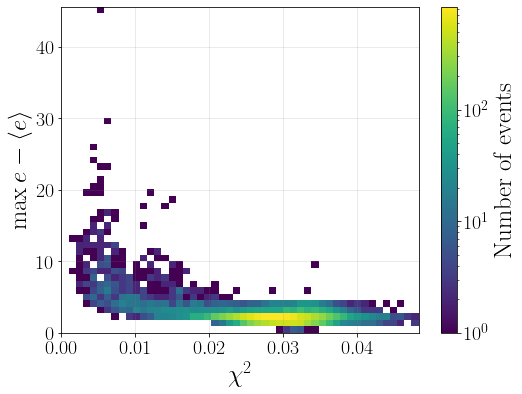

In [74]:
lp.plot_hist2d(
    dataframe['chi2'], dataframe['max_m_mean'],
    "$\chi^2$", column_labels['max_m_mean'],
    logscale=True,
    min_max=[[0., None], [0., None]]
)


### Let's see how discriminative it is

(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:xlabel='$\\chi^2$', ylabel='$\\max{e} - \\langle e \\rangle$'>)

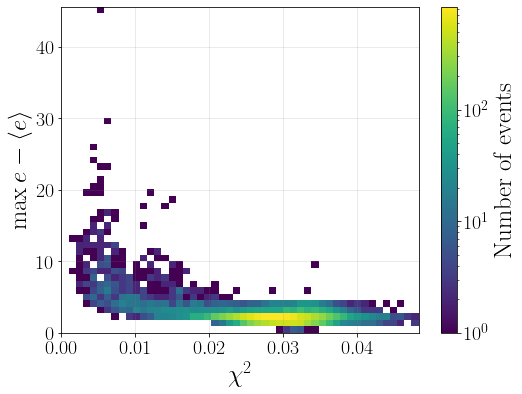

In [61]:
lp.plot_hist2d(
    dataframe['chi2'], dataframe['max_m_mean'],
    "$\chi^2$", column_labels['max_m_mean'],
    logscale=True,
    min_max=[[0., None], [0., None]]
)


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$\\chi^2$', ylabel='Number of events'>)

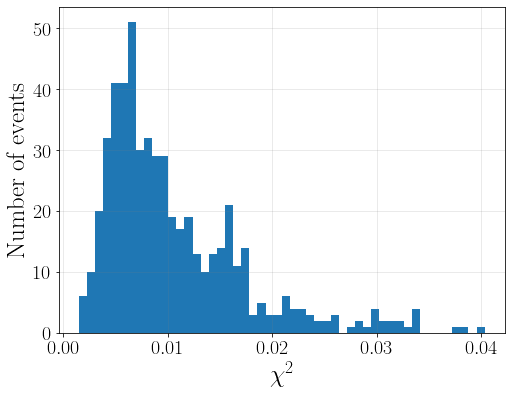

In [62]:
cut_df = dataframe.query("max_m_mean > 4")

lp.plot_hist(cut_df["chi2"], "$\chi^2$")

In [75]:
# lp.plot_samples_lots(cut_df.query("chi2 > 0.02"), minus_mean=True)

What pseudo-rapidity $\eta$ do these events have ?

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$\\eta$', ylabel='Number of events'>)

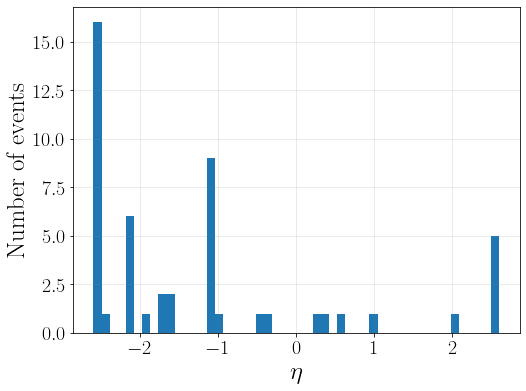

In [76]:
cut_df_high_chi2 = cut_df.query("chi2 > 0.02")

lp.plot_hist(cut_df_high_chi2["eta"], r"$\eta$")

(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:xlabel='$\\eta$', ylabel='$\\chi^2$'>)

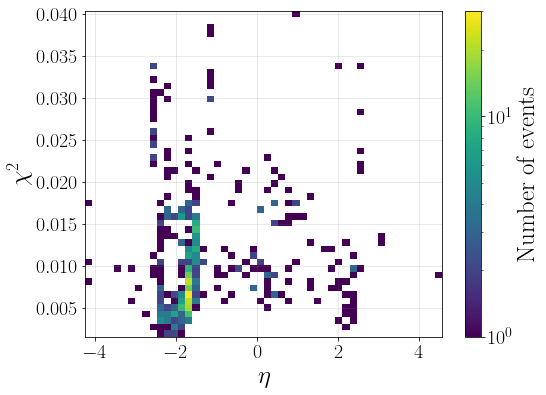

In [77]:
lp.plot_hist2d(
    cut_df["eta"], cut_df["chi2"], r"$\eta$", r"$\chi^2$", logscale=True)

It seems that larger pseudo-rapidity $\eta$ has higher $\chi^2$: that is the events that are less in the center of the detector !

Some of these events look clearly like signal, but their peak seem to suffer from large noise. Thus, the $\chi^2$ is nod good. We could try to optimise the choice of the amplitude the event is multiplied with before computing the $\chi^2$.

### Perform a fit to find the right amplitude
We take one of the event that has a quite large $\chi^2$ and try to perform a fit using different algorithms.

In [83]:
df_high_chi2 = dataframe.query("max - mean > 4 and chi2 > 0.02")
data_cuts.apply_signal_cuts(df_high_chi2)

Cut pos_first_neg_after_max!=-1 -> efficiency 0.06
Cut min_std_pos_neg_redpn > 0.02 -> efficiency 0.0
Cut nb_peaks_sup_80_wrt_min == 1 -> efficiency 0.2765957446808511
Cut pos_max <= 20 -> efficiency 0.23529411764705882


/home/anthony/3A_CS/projet_ATLAS/scripts/clustering/data_cuts.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.query(cut, inplace=True)


In [86]:
event = df_high_chi2.iloc[1]
event[defs.list_samples_columns] = normalize.get_red_df(event)
samples = event[defs.list_samples_columns]
pos_max_i = int(event["pos_max"])
sig_pos_max = np.argmax(sig_array_red_big)
sig_start_pos = sig_pos_max - pos_max_i
sig_end_pos = sig_start_pos + defs.n_samples

scale = compute_chi2.compute_scale(samples, sig_array_red_big)

/home/anthony/anaconda3/envs/ML4LTDB/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/home/anthony/anaconda3/envs/ML4LTDB/lib/python3.8/site-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()
/home/anthony/anaconda3/envs/ML4LTDB/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

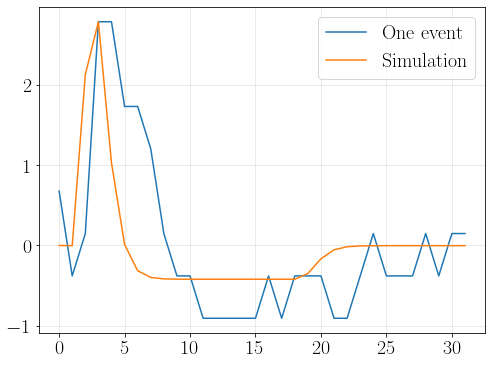

In [87]:
x = np.arange(0, defs.n_samples)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, samples, label="One event")
ax.plot(x, sig_array_red_big[sig_start_pos: sig_end_pos] * scale, label="Simulation")
ax.legend()
lp.set_default_grid(ax)

In [88]:
event["eta"]

-0.3375000059604645

If we try to fit by hand ... First, Let's try to find a better time position.

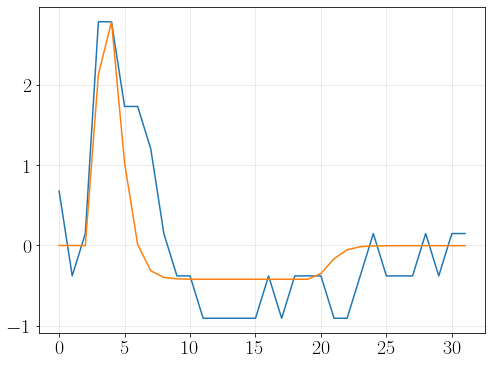

In [90]:
x = np.arange(0, defs.n_samples)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, samples, label="One event")
ax.plot(x, sig_array_red_big[sig_start_pos-1: sig_end_pos-1] * scale, label="Simulation")
lp.set_default_grid(ax) 

Then, we can fix the amplitude.

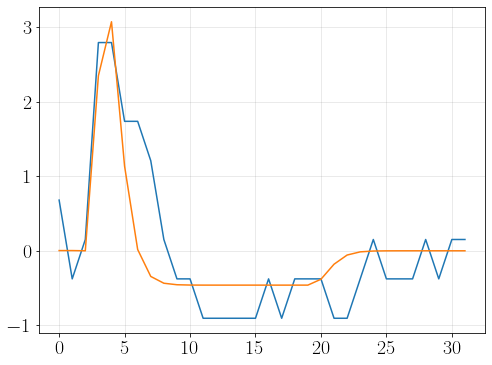

In [91]:
x = np.arange(0, defs.n_samples)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, samples)
ax.plot(x, sig_array_red_big[sig_start_pos-1: sig_end_pos-1]* scale * 1.1)
lp.set_default_grid(ax)

Resulting $\chi^2$

In [92]:
print("Before:", compute_chi2.compute_chi2(samples, sig_array_red_big[sig_start_pos:sig_end_pos]))
print("After:", compute_chi2.compute_chi2(samples, sig_array_red_big[sig_start_pos-1:sig_end_pos-1]*1.1))

Before: 0.02404846990994501
After: 0.019366730234226363


### Automatisation

In [93]:
best_pos_max = compute_chi2.find_best_pos_max(
    np.array(event[defs.list_samples_columns]), sig_array_red_big
)

print("Position of the max", event["pos_max"])
print("Position of the max that minimises the chi2", best_pos_max)  

Position of the max 3.0
Position of the max that minimises the chi2 4


To find the amplitude, we minimise the $\chi^2$

Let's first see how $\chi^2$ depends on the $A$ amplitude parameter

Text(0, 0.5, '$\\chi^2$')

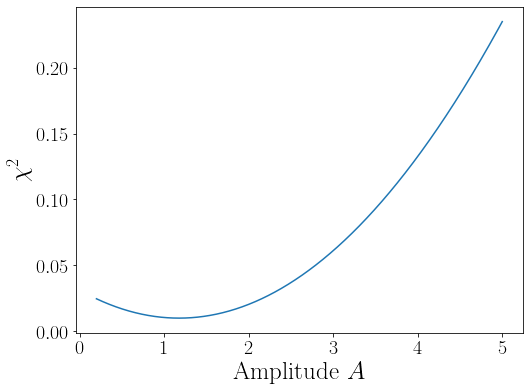

In [94]:
array_A = np.linspace(1/5, 5, 1000)

# Signal indices -------------------------------------
sig_start_pos = sig_pos_max - best_pos_max
sig_end_pos = sig_start_pos + defs.n_samples

# Array (amplitude, samples for this amplitude)
array_event = np.repeat(
    np.array(event[defs.list_samples_columns]).reshape(defs.n_samples, 1), 
    len(array_A), axis=1).T

# Array (amplitude, signal for this amplitude * correct scaling)
array_signal_A = np.repeat(
    sig_array_red_big[sig_start_pos:sig_end_pos].reshape(defs.n_samples, 1), 
    len(array_A), axis=1).T * \
        np.repeat(array_A.reshape(len(array_A), 1), defs.n_samples, axis=1) * scale

# data - signal shape * sampliing factor
array_chi2 = np.mean(np.square(
        array_event - array_signal_A
    ), axis=1) / defs.n_samples 


# Figure
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(array_A, array_chi2)
ax.set_xlabel("Amplitude $A$")
ax.set_ylabel("$\chi^2$")

It's quite smooth. Let's implement the Brent method.

In [95]:
from scipy.optimize import minimize_scalar
from typing import Optional

def find_best_ampl(
    event_array: np.array, sig_array:np.array,
    pos_max: Optional[int] = -1,
    pos_max_modif: Optional[int] = -1, 
    sig_pos_max: Optional[int] = -1,
    ampl_var=1.3, verbose: bool = False
)->float:
    """ Scipy version to find the amplitude of
    the signal that minimises the $\chi^2$ between
    the `event_array` and 
    `sig_array * max(event_array) / max(sig_array)`

    Array:
        event_array: one event
        sig_array: the simulated signal version of an event
        pos_max: position of the max of `event_array`.
            If not given, it is recomputed.
        pos_max_modif: Optimised position of the max of `event_array`.
            If not given, taken to be `pos_max`.
        sig_pos_max: position of the max of `signal_array`.
            If not given, it is recomputed.
        ampl_var: the optimal :math:`\chi^2` is searched between
            `1 / ampl_var` and `ampl_var` multiplied by the
            maximum of `event_array` (that is, the default value).
        verbose: whether the summary of the fit is plotted
    
    Returns:
        best_A, best_chi2: best amplitude and :math:`\\chi^2`
            for this value.    
    """

    ## Compute the position of the max, if not given -------
    if sig_pos_max == -1:
        sig_pos_max = np.argmax(sig_array)
    if pos_max_modif == -1:
        if pos_max == -1:
            pos_max = np.argmax(event_array)
        pos_max_modif = pos_max

    
    ## Minimise the chi2 ----------------------------------
    bounds = (1/ampl_var, ampl_var)
    sig_start_pos = sig_pos_max - pos_max_modif
    sig_end_pos = sig_start_pos + defs.n_samples
    scale = compute_chi2.compute_scale_numba(
        event_array, sig_array, pos_max, sig_pos_max
    )
    def compute_chi2_ampl(
        A: float
    ):
        """
        Function :math:`\\chi^2` to minimise w.r.t. the :math:`A`
        parameter.

        Args:
            A: what the amplitude of the signal is
                multiplied with.
        Returns:
            chi2: :math:`\\chi^2` for the amplitude
                :math:`A`
        """
        return compute_chi2.compute_chi2_numba(
            event_array, 
            sig_array[sig_start_pos:sig_end_pos] * A * scale
        ) 
    
    # Scipy minimisation
    result = minimize_scalar(
        compute_chi2_ampl, bounds=bounds, method="bounded",
        options = {"maxiter" : 10}
    )

    default_chi2 = compute_chi2_ampl(A=1.)
    ## Return the result if the minimisation succeeded ----
    if result.success:
        A = result.x
        best_chi2 = result.fun
        if best_chi2 > default_chi2:
            best_chi2 = default_chi2
    else: 
        A = 1.
        best_chi2 = default_chi2
    
    if verbose:
        print(result)
    
    return A, best_chi2


In [96]:
A, best_chi2 = find_best_ampl(
    np.array(event[defs.list_samples_columns]), 
    sig_array_red_big, pos_max_modif=best_pos_max,
    verbose=True
)

     fun: 0.009915193458382446
 message: 'Solution found.'
    nfev: 6
     nit: 6
  status: 0
 success: True
       x: 1.1768463483148786


In [97]:
sig_start_pos = sig_pos_max - best_pos_max
sig_end_pos = sig_start_pos + defs.n_samples

x = np.arange(0, defs.n_samples)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, samples)
ax.plot(x, sig_array_red_big[sig_start_pos: sig_end_pos] * A * scale)
lp.set_default_grid(ax)

In [98]:
print(
    compute_chi2.compute_chi2(
        event[defs.list_samples_columns], 
        sig_array_red_big[sig_start_pos:sig_end_pos] * A * scale
    )
)
print("Should be the same value: ", best_chi2)

0.009915193458382448
Should be the same value:  0.009915193458382446


### Clean function with numba

In [99]:
## Test

compute_chi2.find_best_ampl_numba(
    np.array(event[defs.list_samples_columns]), 
    sig_array_red_big, pos_max_modif=best_pos_max,
)

0.009915193458382446

In [100]:
chi2 = compute_chi2.compute_chi2_dataframe_to_sig_optimised(
   dataframe
)
dataframe["best_chi2"] = chi2

chi2 = compute_chi2.compute_chi2_dataframe_to_sig_optimised(
   dataframe, divide_by="max_m_mean"
)
dataframe["best_chi2_max"] = chi2

### Tests

In [106]:
from project import loc
fig, ax = lp.multi_plot_hist2d(
    [dataframe['chi2'], dataframe['best_chi2']], [dataframe['max_m_mean'], dataframe['max_m_mean']],
    "$\chi^2$", column_labels['max_m_mean'],
    list_labels = ["Default", "Optimised"],
    logscale=True,
    min_max=[[0., None], [0., None]],
    one_ax=False,
    return_fig=True
)

lp.save_fig(fig, op.join(loc.images_folder, "signal"), "chi2_comparison")


# fig, ax = lp.multi_plot_hist2d(
#     [dataframe['chi2_max'], dataframe['best_chi2_max']], [dataframe['max_m_mean'], dataframe['max_m_mean']],
#     "Max $\chi^2$", column_labels['max_m_mean'],
#     list_labels = ["Default", "Optimised"],
#     logscale=True,
#     min_max=[[0., None], [0., None]],
#     one_ax=False
# )
# lp.save_fig(fig, op.join(loc.image_path, "signal"), "chi2_non_optimised")


Create the folders in /mnt/d/900GeV//output//images/signal
Fig saved in /mnt/d/900GeV//output//images/signal/chi2_comparison.png
Fig saved in /mnt/d/900GeV//output//images/signal/chi2_comparison.pdf


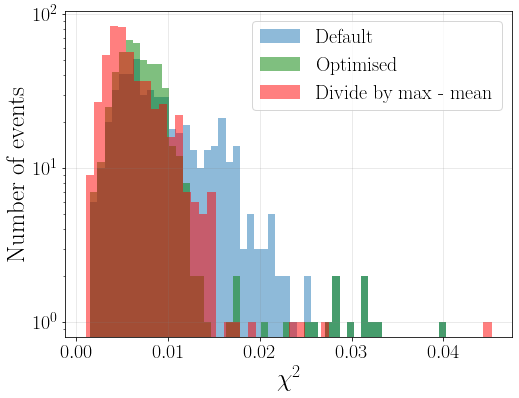

In [37]:
cut_df = dataframe.query("max_m_mean > 4")
fig, ax = plt.subplots(figsize=(8, 6))
lp.plot_hist(cut_df["chi2"], "$\chi^2$", ax=ax, label="Default", alpha=0.5)
lp.plot_hist(cut_df["best_chi2"], "$\chi^2$", ax=ax, label="Optimised", color='g', alpha=0.5, logscale=True)
lp.plot_hist(cut_df["best_chi2_max"]*10, "$\chi^2$", ax=ax, label="Divide by max - mean", color='r', alpha=0.5, logscale=True)

ax.legend()

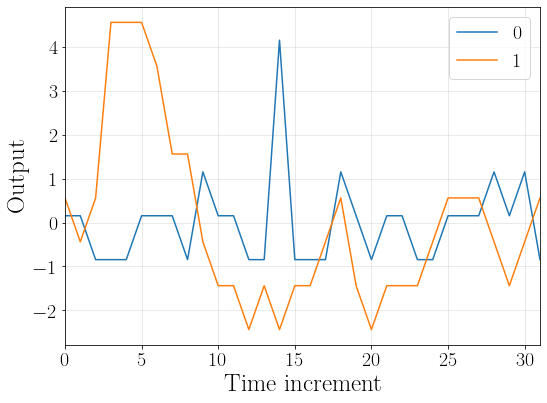

In [42]:
lp.plot_samples_lots(cut_df.query("best_chi2_max > 0.002"), minus_mean=True)

Dividing by `max - mean` is worse !

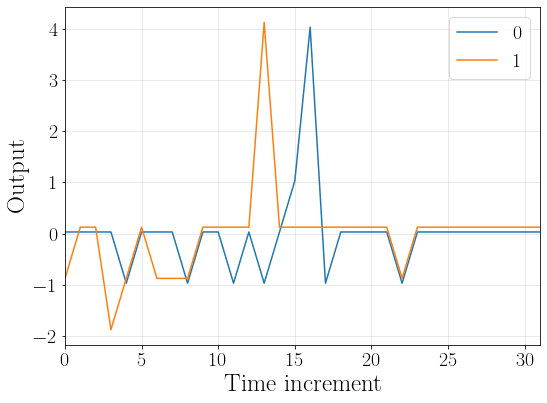

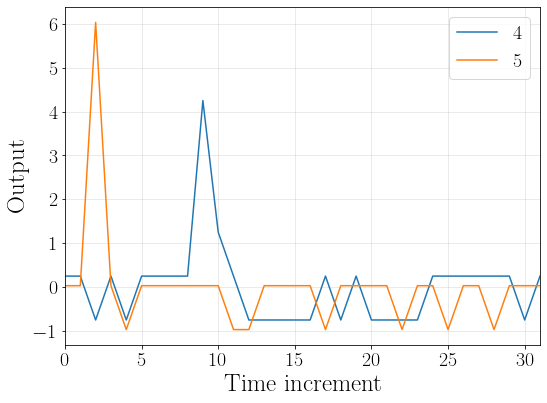

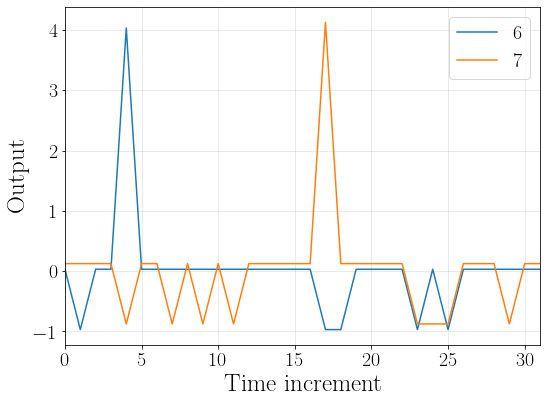

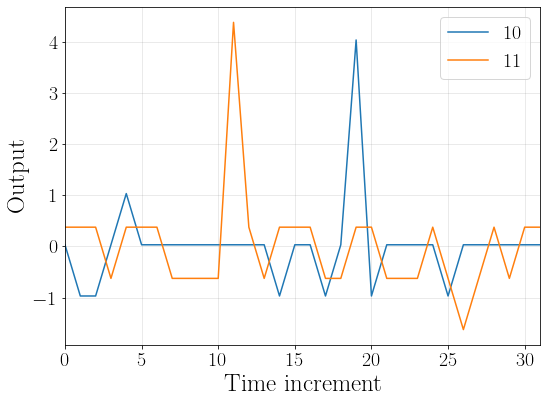

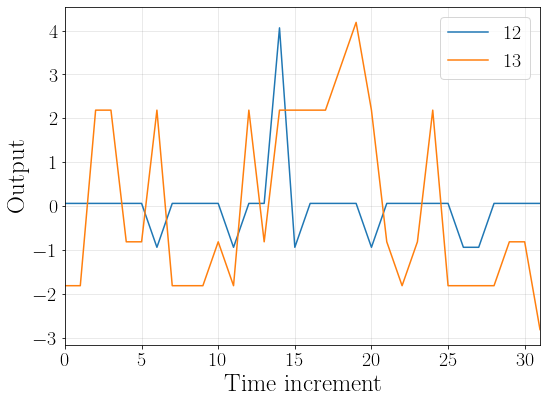

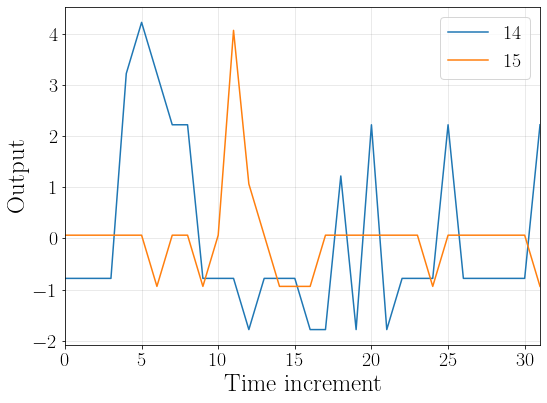

In [42]:
lp.plot_samples_lots(cut_df.query("best_chi2 > 0.015"), minus_mean=True)

It might be discutable, these "high" $\chi^2$ doesn't look so much like signal !

In [43]:
max_best_chi2 = 0.015
print(f"What if we only keep events with best_chi2 < {max_best_chi2}")
print(len(dataframe.query(f"best_chi2 < {max_best_chi2}"))/len(dataframe))
print(len(dataframe.query(f"best_chi2 < {max_best_chi2}")))

What if we only keep events with best_chi2 < 0.015
0.007125873100432304
3839


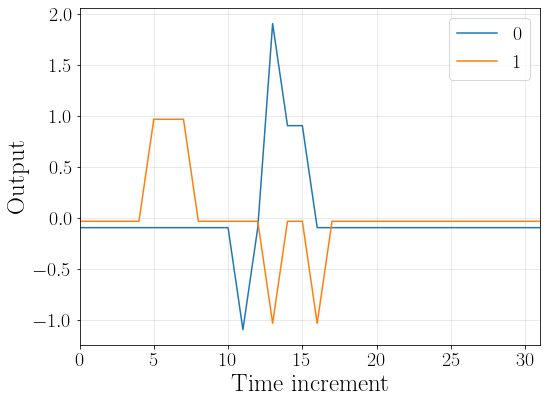

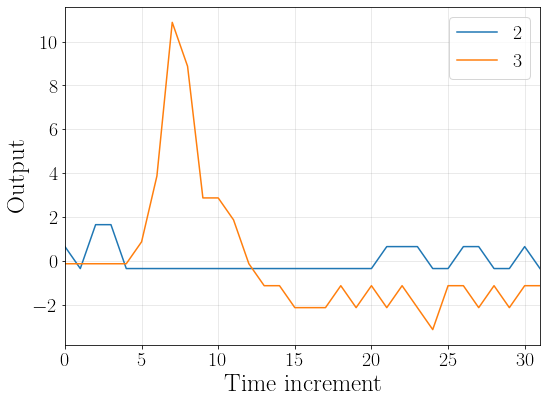

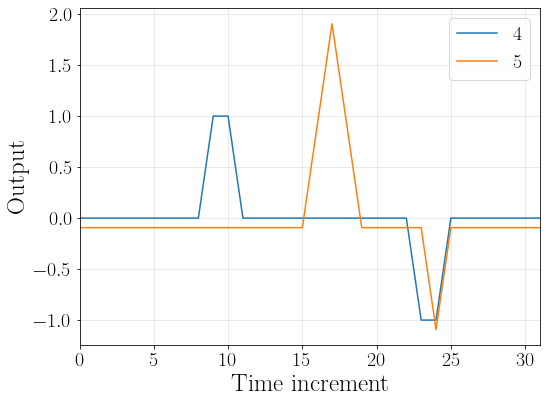

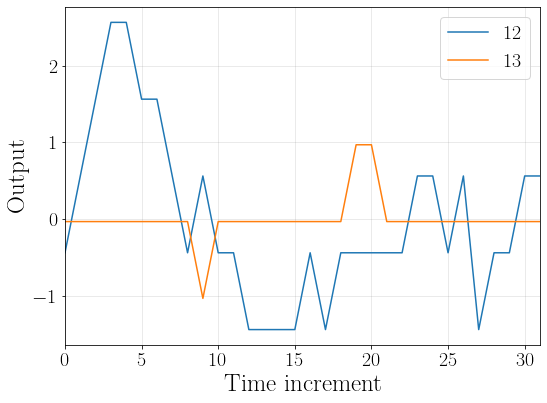

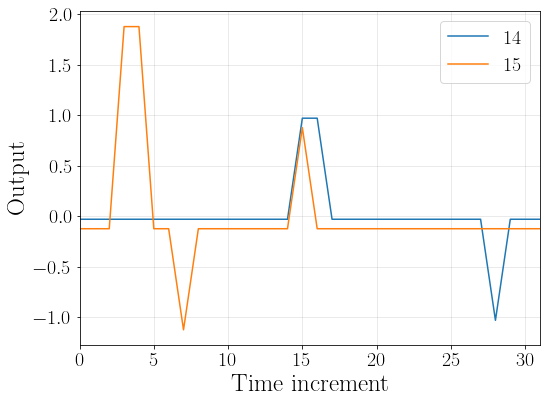

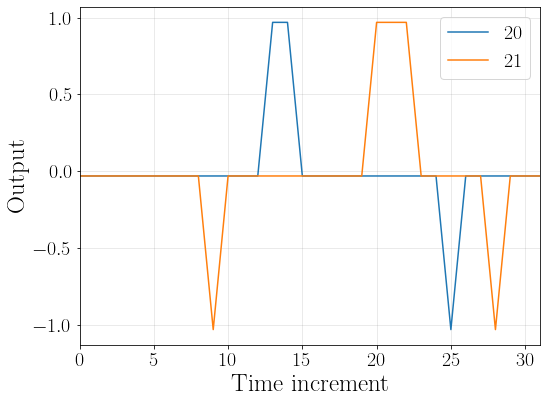

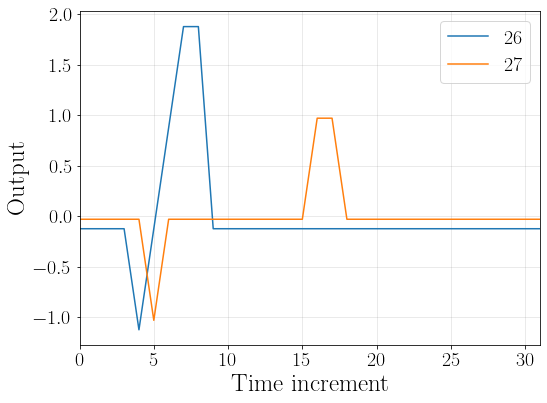

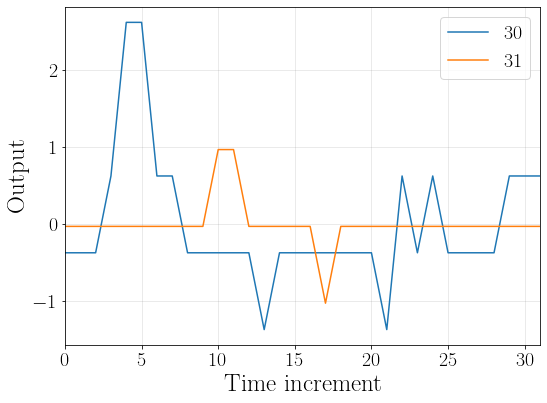

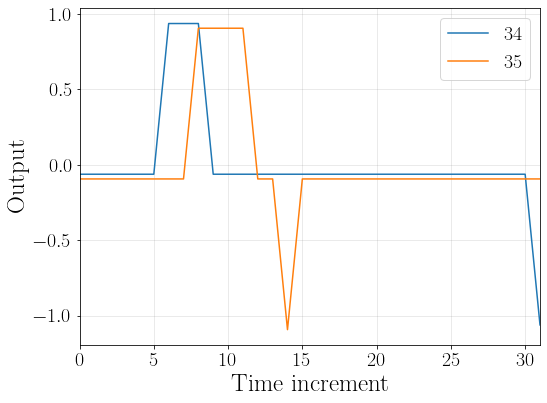

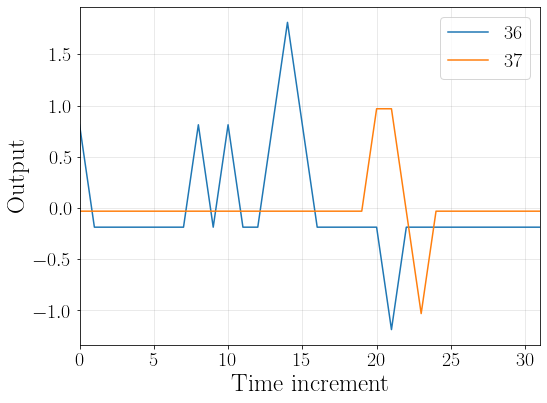

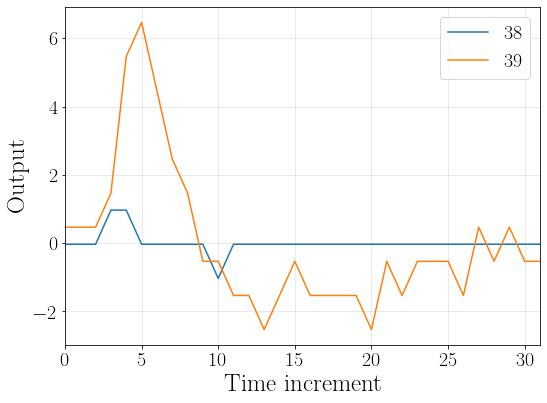

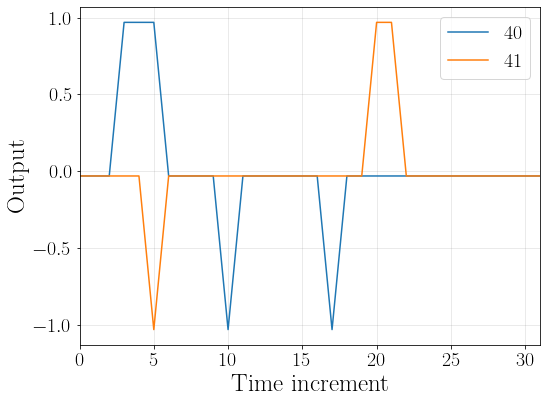

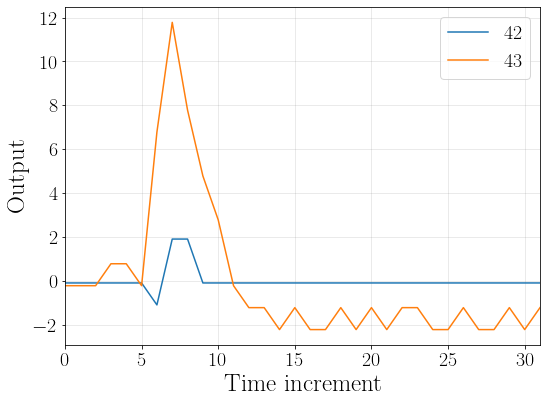

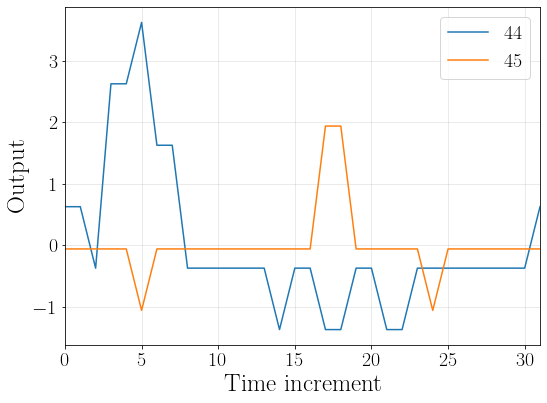

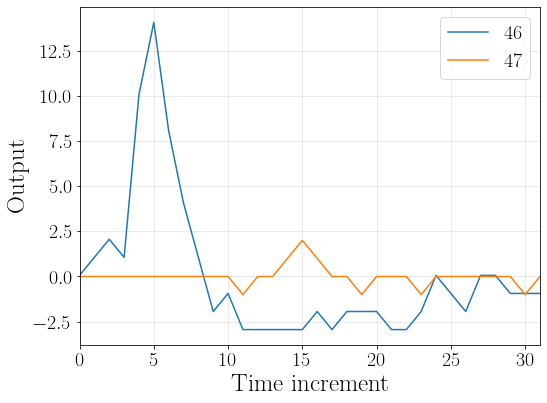

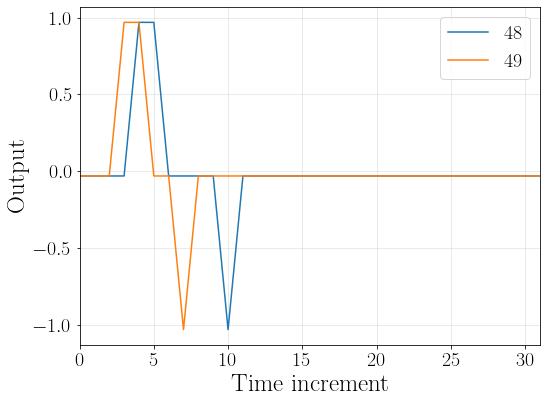

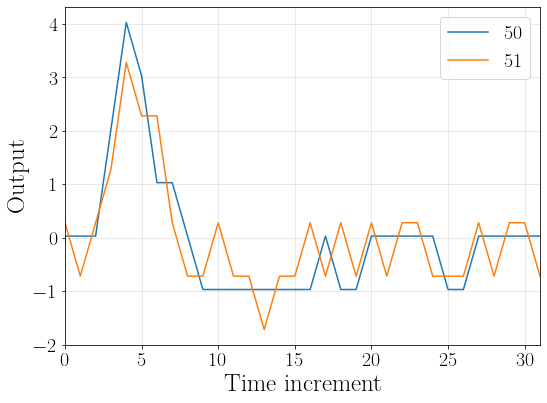

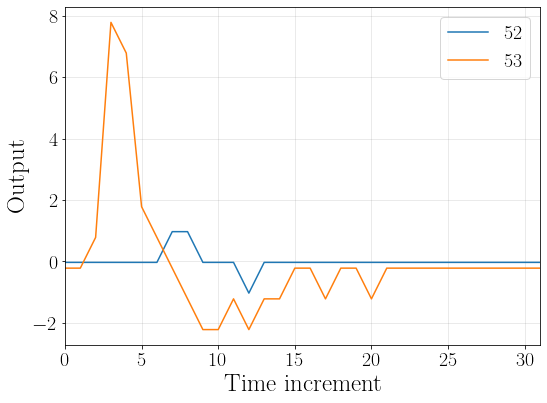

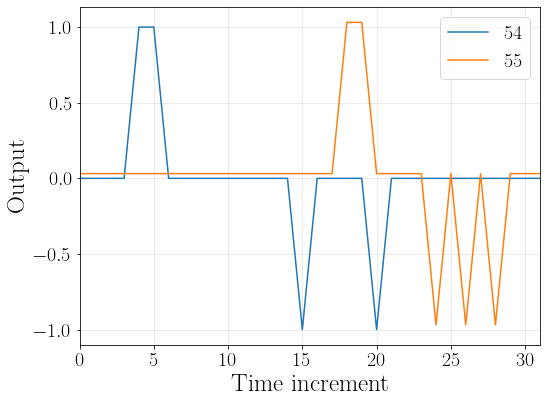

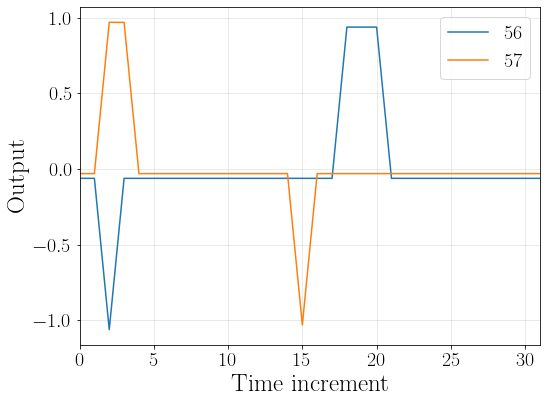

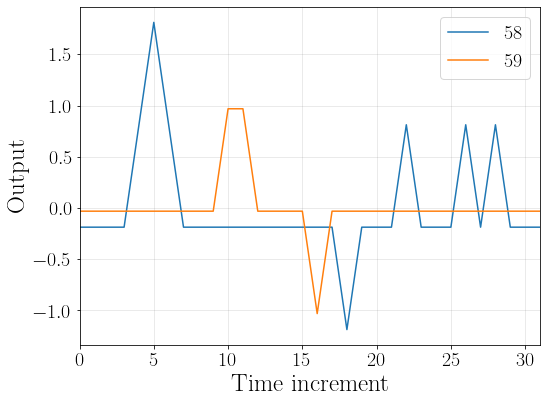

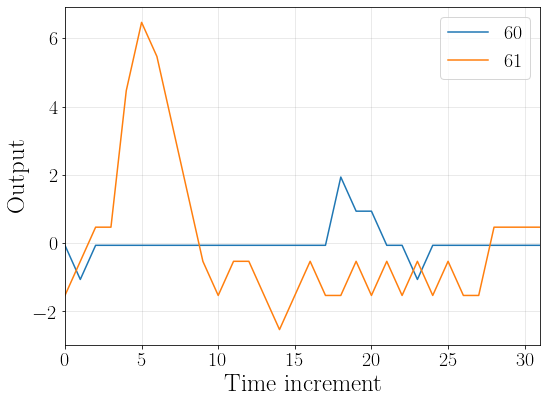

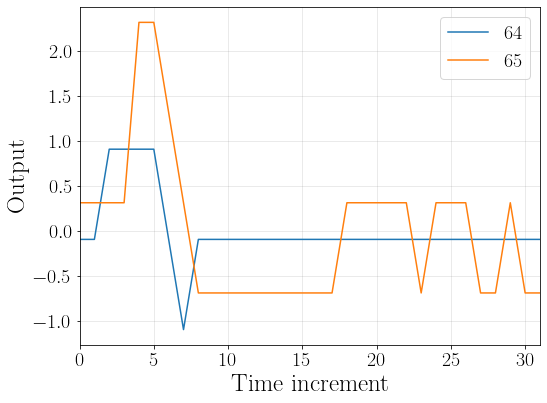

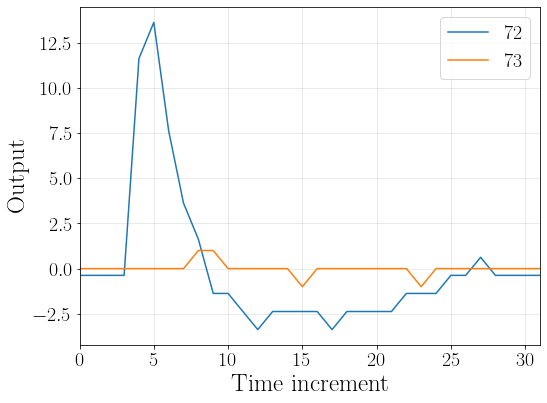

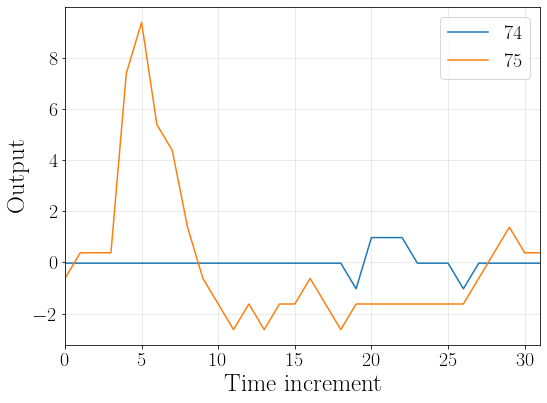

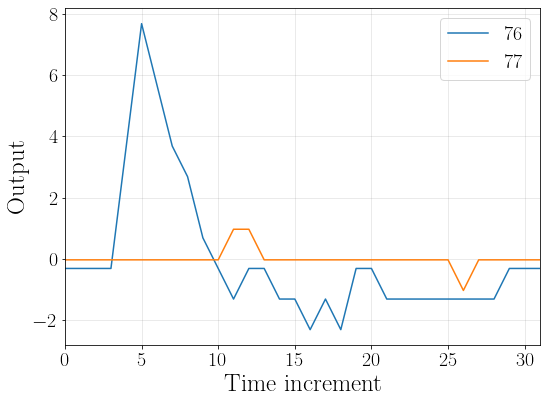

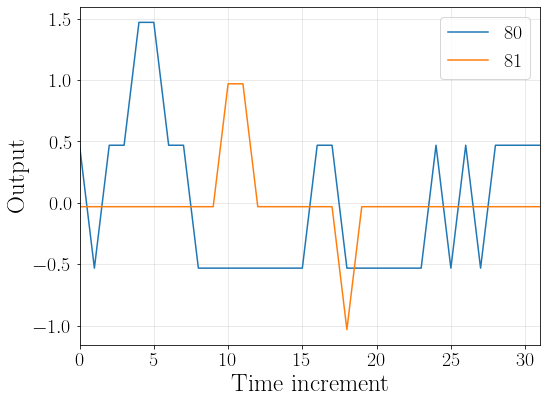

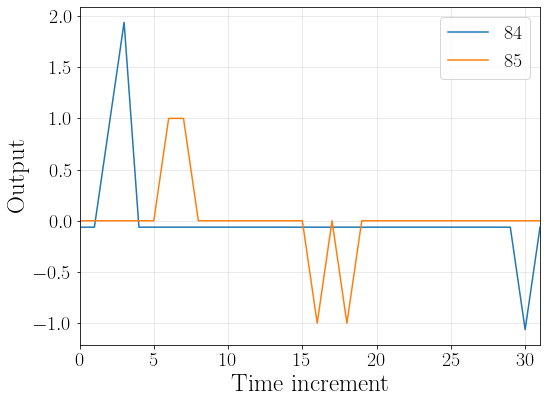

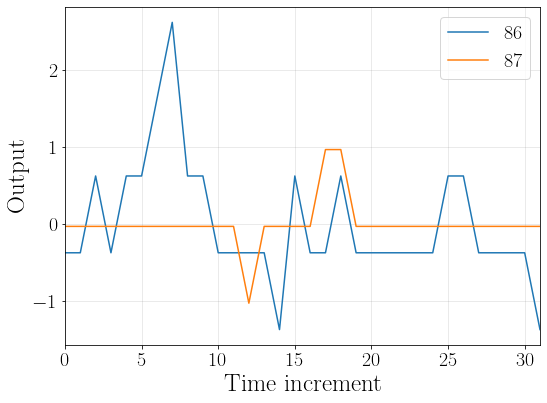

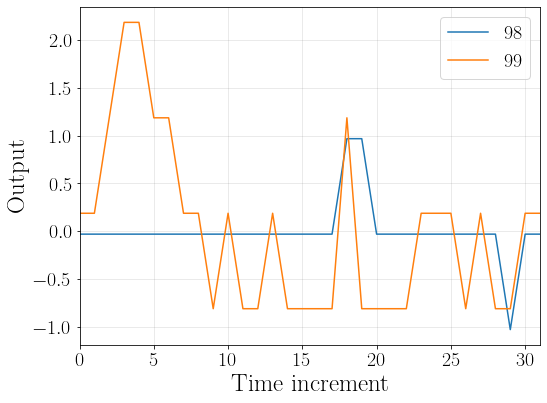

In [46]:
lp.plot_samples_lots(dataframe.query(f"best_chi2 < {max_best_chi2}").sample(100), minus_mean=True)

## Let's try clustering with it ...

In [44]:
import hdbscan
clu_label_name = "HDBSCAN"
clu_label_alias = "HDBSCAN"

In [46]:
dataframe["mean_m_pedestal"] = dataframe["mean"] - dataframe["pedestal"]
column_labels["mean_m_pedestal"] = r"$\langle e \rangle - e_0$"

features = defs.list_samples_columns

features_plot = [
    "best_chi2",
]

# def normalise_columns(dataframe, columns):
#     for column in columns:
#         max_column = dataframe[column].max()
#         min_column = dataframe[column].min()
#         dataframe[column + '_norm'] = (dataframe[column] - min_column) / (max_column - min_column)


In [47]:
randomise_discretisation_clu = True

In [54]:
dataframe_low_chi2 = dataframe.query(f"best_chi2 < {max_best_chi2}")

clustering_dataframe = deepcopy(dataframe_low_chi2)
if randomise_discretisation_clu:
    files.randomise_discretisation(clustering_dataframe)
clustering_dataframe = normalize.get_red_df(clustering_dataframe, return_pd=True)
normalize.get_dataframe_pos_max_lined_up(
    clustering_dataframe
)

Time taken: 0.0010802745819091797


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Time increment', ylabel='Output'>)

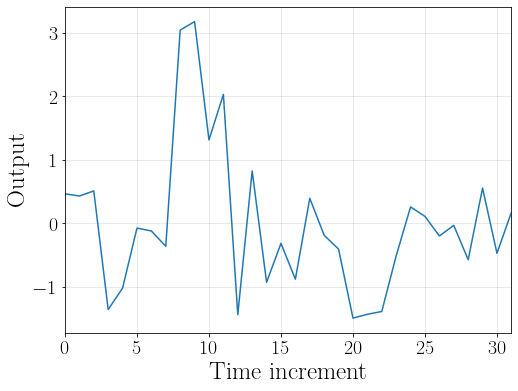

In [55]:
lp.plot_event(clustering_dataframe.iloc[0][defs.list_samples_columns])

In [56]:
clusterer = hdbscan.HDBSCAN(
    algorithm='best', 
    metric='euclidean',
    min_cluster_size=10,
    min_samples=1,
    # cluster_selection_epsilon=2.9,
)

clusterer = clusterer.fit(clustering_dataframe[features])
clustering_dataframe[clu_label_name] = clusterer.labels_
dataframe_low_chi2[clu_label_name] = clusterer.labels_


/tmp/ipykernel_4055/733890966.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_low_chi2[clu_label_name] = clusterer.labels_


#### Taille des clusters

In [57]:
np.unique(clustering_dataframe[clu_label_name])

array([-1,  0,  1])

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='HDBSCAN', ylabel='Number of events'>)

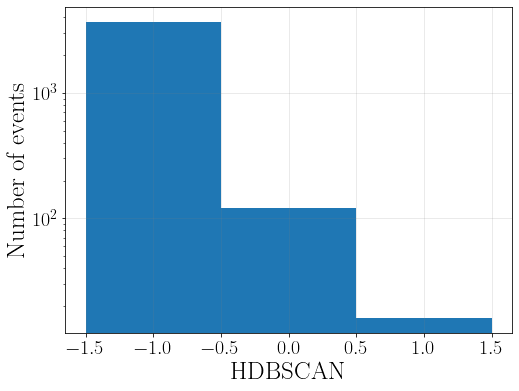

In [58]:
bins = clustering.get_edges_from_clust_labels(
    clusterer.labels_
)

lp.plot_hist(
    clustering_dataframe[clu_label_name],
    clu_label_alias,
    logscale=True,
    bins=bins,
)

### Caractéristique des clusters

In [59]:
from project.defs_range import column_ranges, column_nbins

In [60]:
column_nbins["pos_max"] = 32

{'best_chi2_max_m_mean': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x432 with 6 Axes>),
 'best_chi2_pos_max': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x432 with 6 Axes>),
 'max_m_mean_pos_max': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x432 with 6 Axes>)}

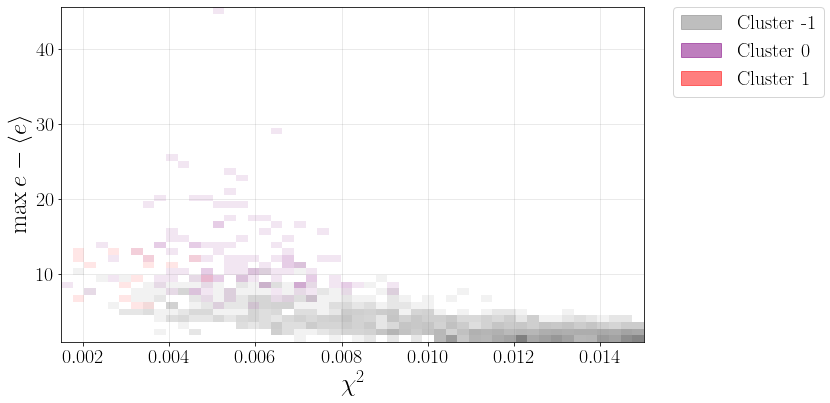

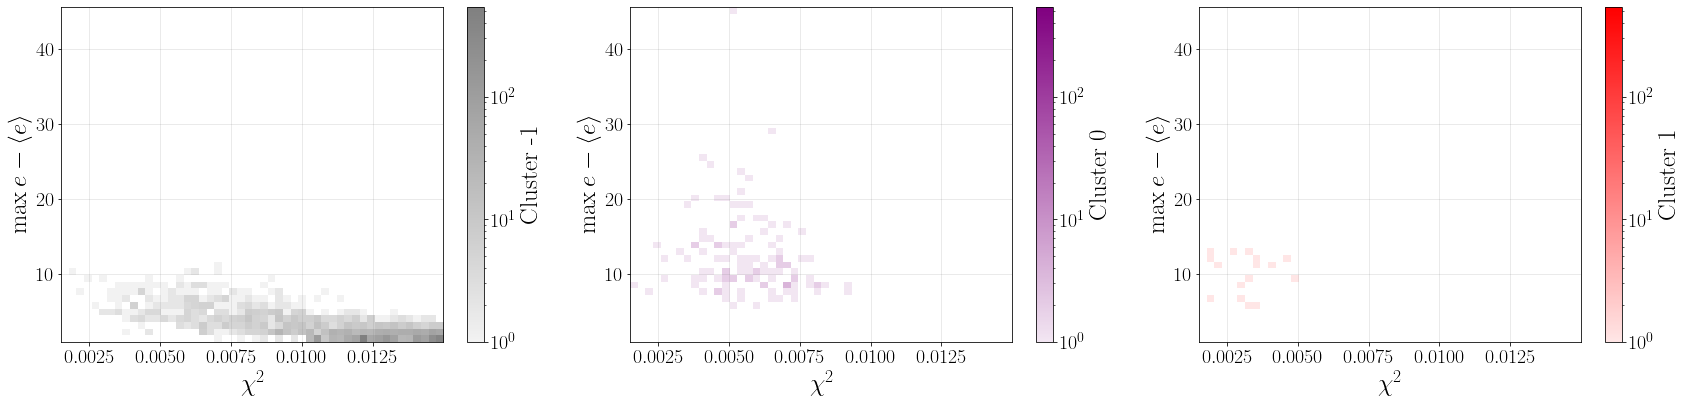

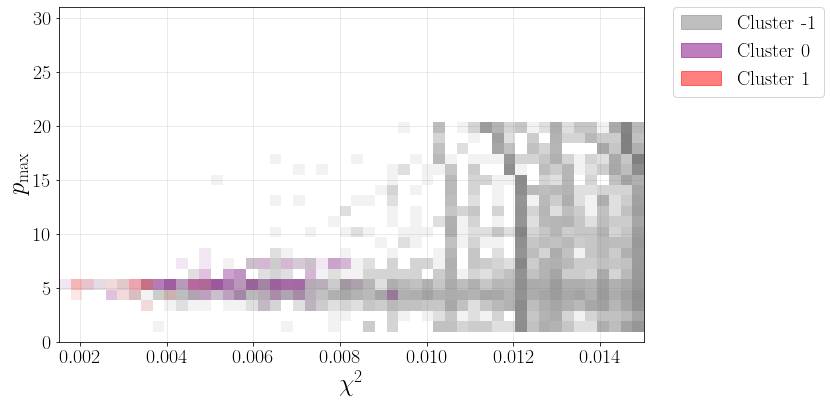

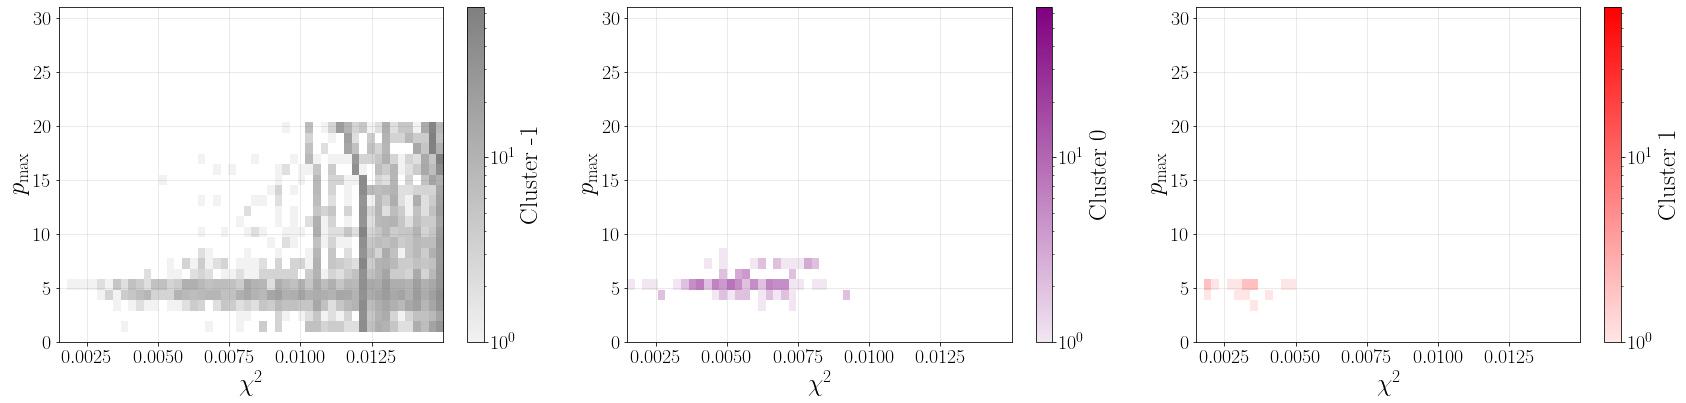

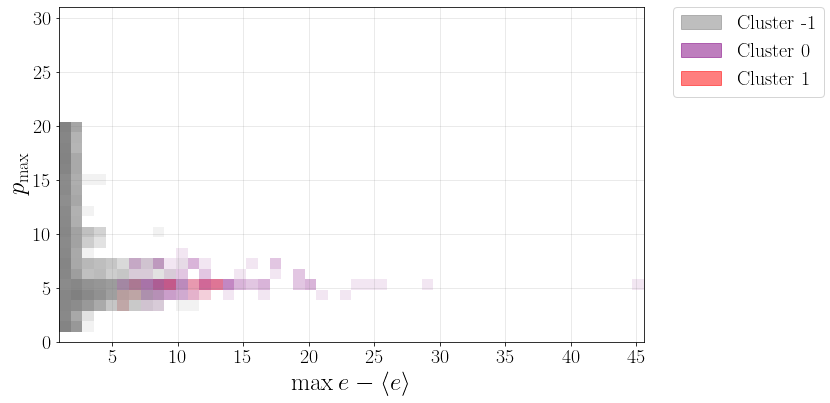

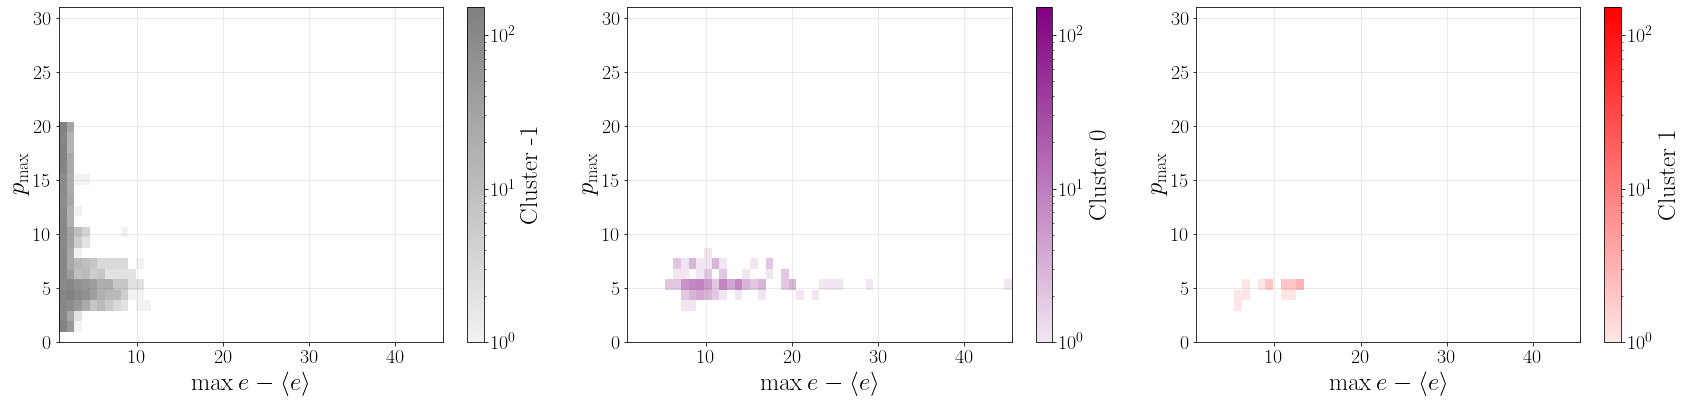

In [61]:
column_labels["chi2"] = r"$\chi^2$"
column_labels["best_chi2"] = r"$\chi^2$"

clustering.plot_clusters_hist2d(
    dataframe_low_chi2, 
    features_plot + ['max_m_mean', "pos_max"],
    column_labels,
    clu_label_name,
    logscale=True,
    dict_color_clu_cats=defs.dict_color_clu_labels,
    column_ranges=column_ranges,
    column_nbins=column_nbins
)



{'eta_phi': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x432 with 6 Axes>)}

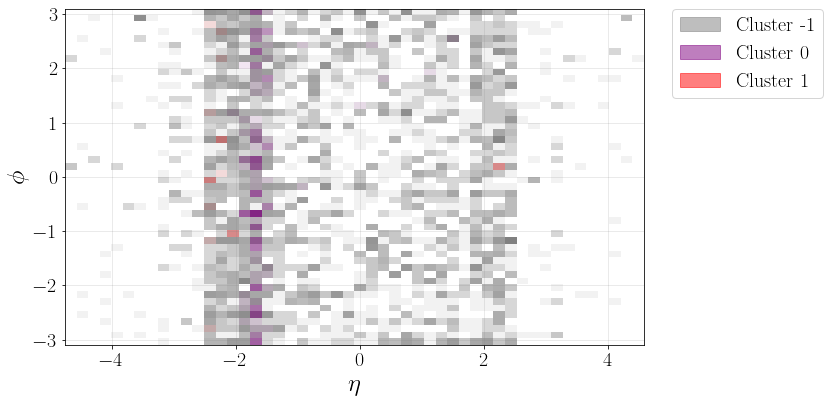

In [62]:
column_labels["eta"] = r"$\eta$"
column_labels["phi"] = r"$\phi$"


clustering.plot_clusters_hist2d(
    dataframe_low_chi2, 
    ['eta', "phi"],
    column_labels,
    clu_label_name,
    logscale=True,
    dict_color_clu_cats=defs.dict_color_clu_labels,
    column_ranges=column_ranges,
    column_nbins=column_nbins
)

In [64]:
plot_df = deepcopy(dataframe_low_chi2)
plot_df[defs.list_samples_columns] -= data.get_1D_to_2D(plot_df["mean"])
plot_df[defs.list_samples_columns] /= data.get_1D_to_2D(plot_df["max_m_mean"])
# normalize.get_dataframe_pos_max_lined_up(
#         plot_df, inplace=True
# )
plot_df[clu_label_name] = np.array(dataframe_low_chi2[clu_label_name])


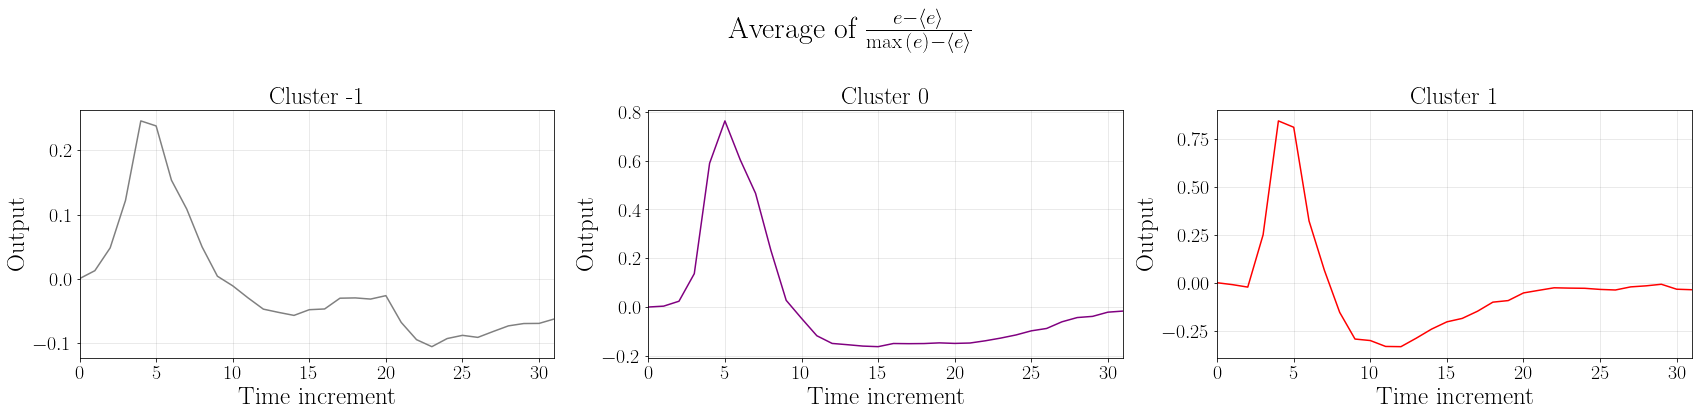

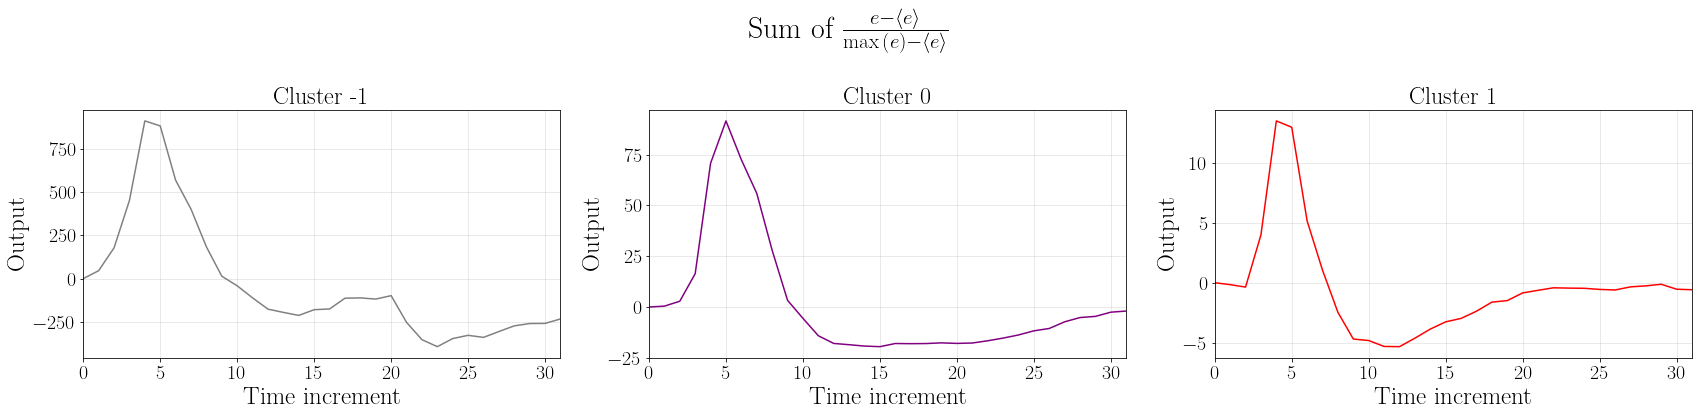

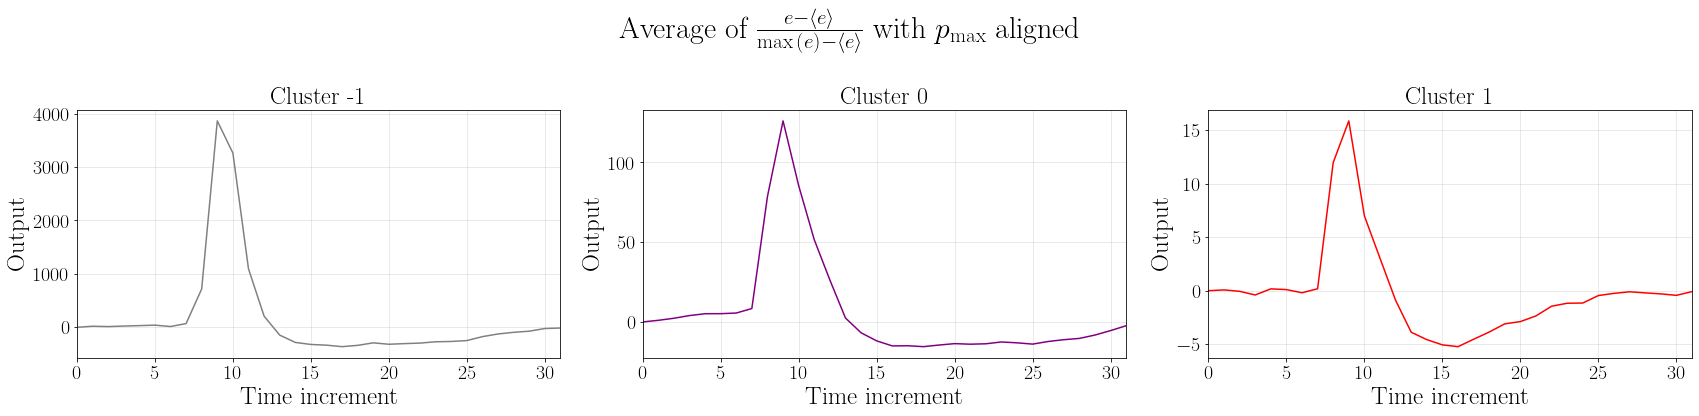

In [65]:
fig, _ = clustering.plot_samples_clusters(
    plot_df,
    clu_label_name,
    dict_color_clu_labels=dict_color_clu_labels,
    method="average"
)

fig.suptitle(r"Average of $\frac{e - \langle e\rangle}{\max{\left(e\right)} - \langle e \rangle}$", fontsize=30)
plt.tight_layout()
plt.show(fig)
plt.close(fig)


fig, _ = clustering.plot_samples_clusters(
    plot_df,
    clu_label_name,
    dict_color_clu_labels=dict_color_clu_labels,
    method="sum"
)

fig.suptitle(r"Sum of $\frac{e - \langle e\rangle}{\max{\left(e\right)} - \langle e \rangle}$", fontsize=30)
plt.tight_layout()
plt.show(fig)
plt.close(fig)

normalize.get_dataframe_pos_max_lined_up(
        plot_df, inplace=True
)

fig, _ = clustering.plot_samples_clusters(
    plot_df,
    clu_label_name,
    dict_color_clu_labels=dict_color_clu_labels,
    method="sum"
)

fig.suptitle(r"Average of $\frac{e - \langle e\rangle}{\max{\left(e\right)} - \langle e \rangle}$ with $p_{\text{max}}$ aligned", fontsize=30)
plt.tight_layout()
plt.show(fig)
plt.close(fig)

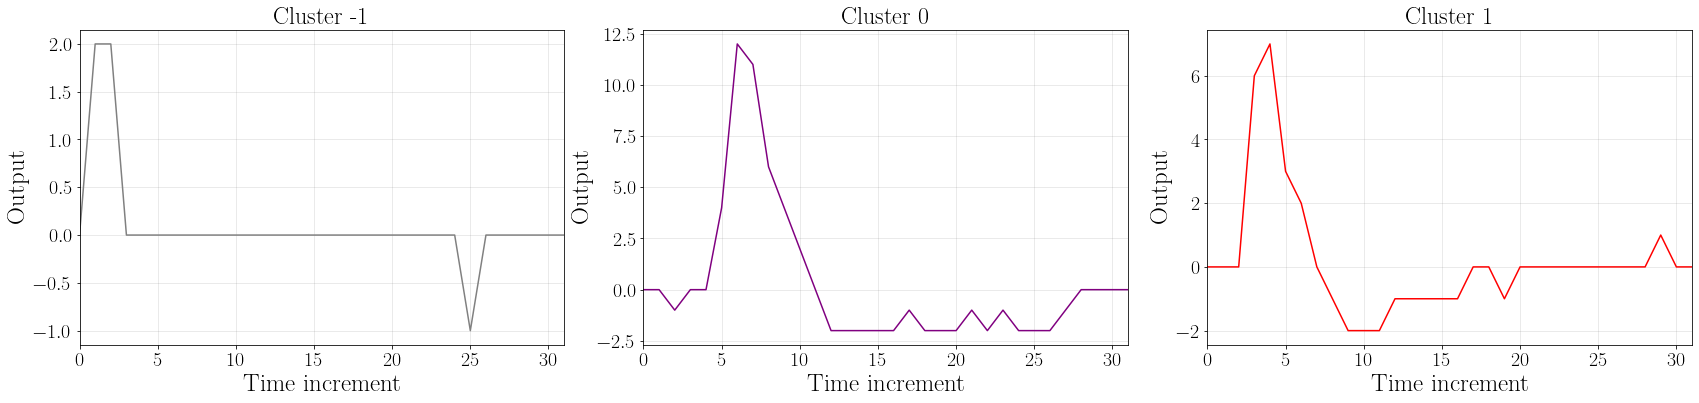

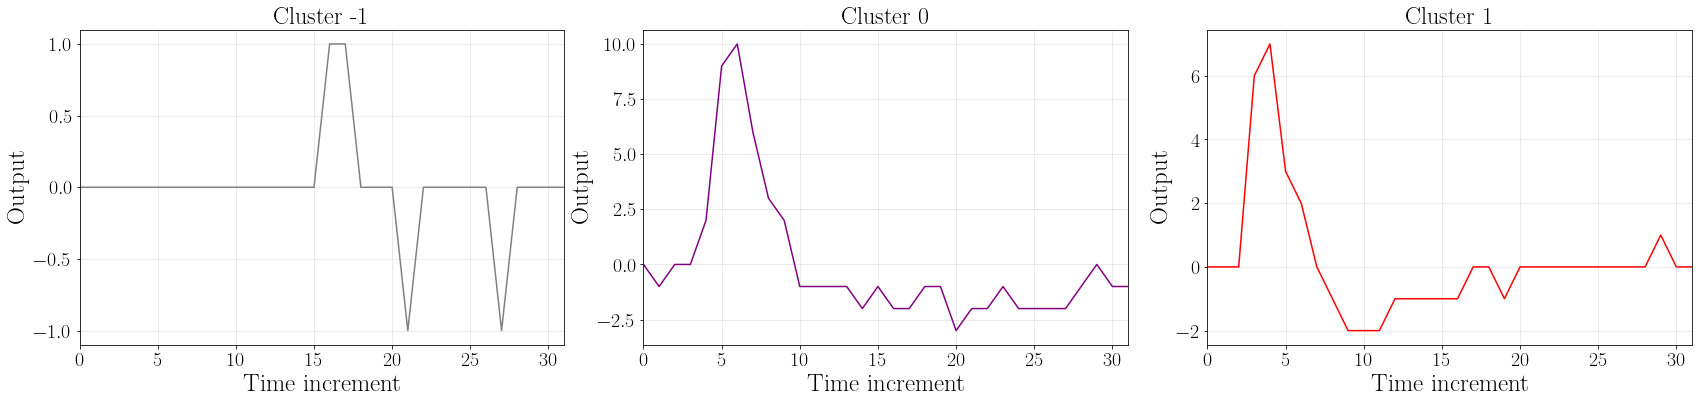

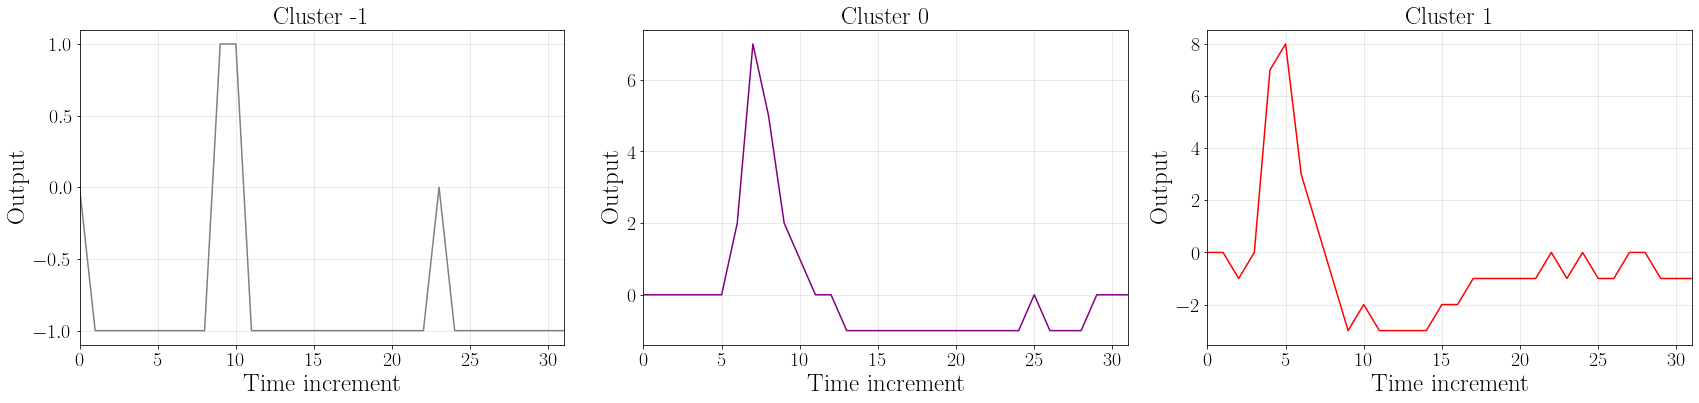

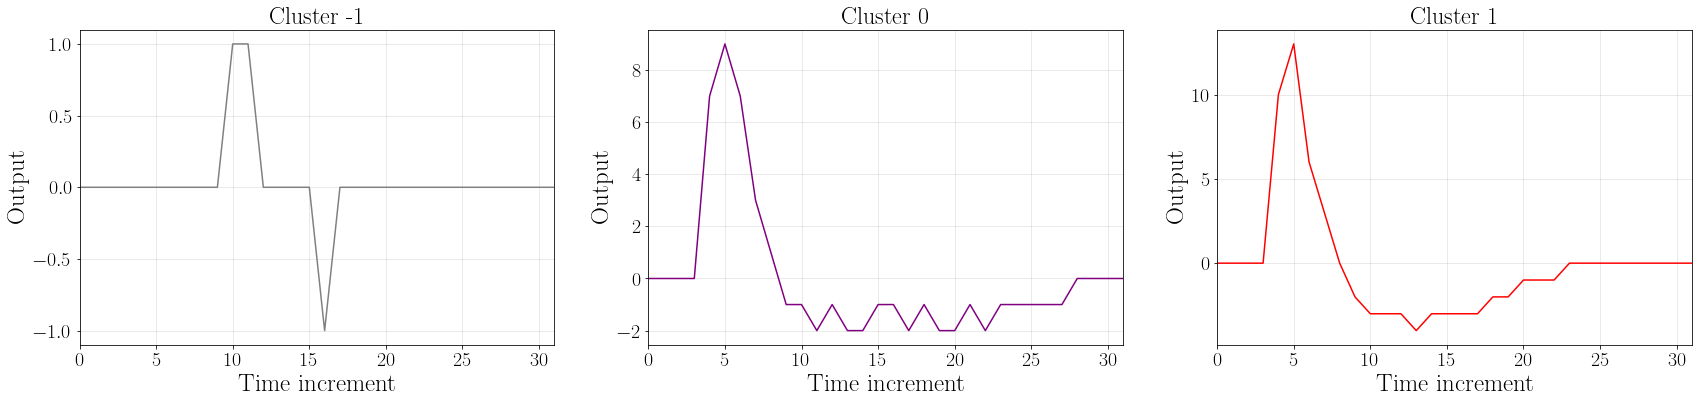

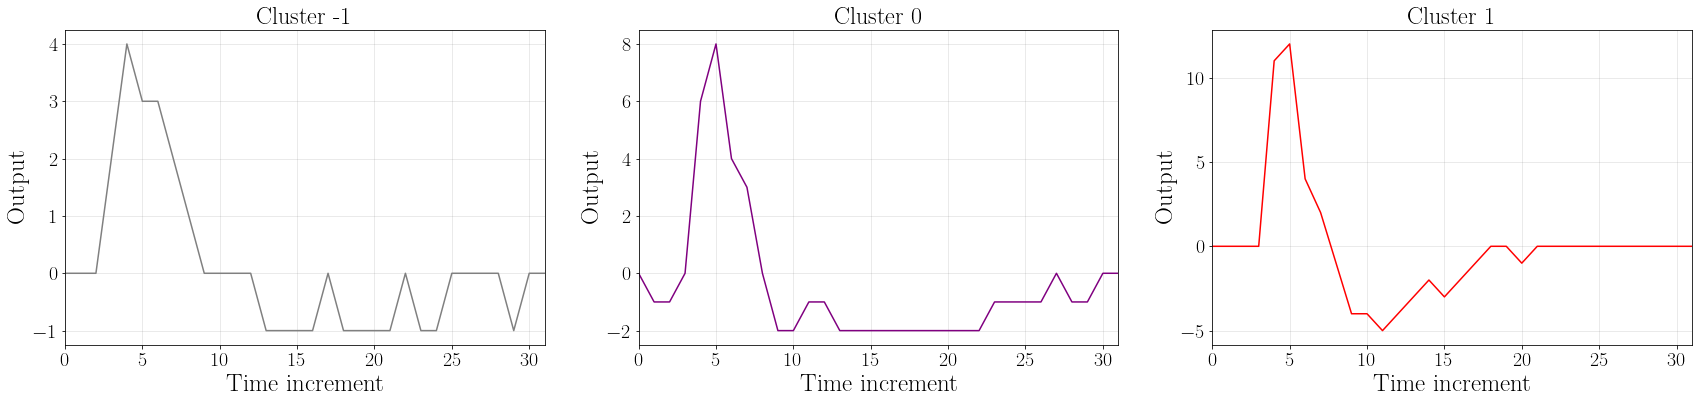

In [68]:
for i in range(5):
    clustering.plot_samples_clusters(
        dataframe_low_chi2,
        clu_label_name,
        dict_color_clu_labels=dict_color_clu_labels,
    )